## LOADING PACKAGES ##

In [1]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
## Tutorial: https://www.kaggle.com/kanncaa1/time-series-prediction-tutorial-with-eda

## EXPLORATION DATA ##

In [2]:
df = pd.concat([pd.read_csv(data) for data in glob("data/*.csv")])
df.head()

,Date,Symbole,Titre,Cotation_Volume,Cotation_Valeur,Cours_Precedent,Cours_Ouv,Cours_Clot,Cours_Moy,Variation,Variation_Ann_Prec,Cours_Reference,Ecarts_Maximaux_Bas,Ecarts_Maximaux_Haut,Dernier_Dividende_Montant_Net,Dernier_Dividende_Date,Comp,Rdt_Net,PER
0,2016-08-09,CABC,SICABLE CI,NaN,NaN,109 000,NC,NC,NC,NaN,"-11,74%",109 000,100 825,117 175,"1 200,00",28/07/2016,1er,"1,10%","23,01"
1,2016-08-09,FTSC,FILTISAC CI,12,328 800,29 500,27 400,27 400,27 400,"-7,12%","-8,65%",27 400,25 345,29 455,"1 045,00",30/06/2016,1er,"3,81%","24,59"
2,2016-08-09,NEIC,NEI-CEDA CI,NaN,NaN,3 455,NC,NC,NC,NaN,"-17,74%",3 455,3 200,3 710,"9,00",12/08/2011,1er,"0,00%","0,00"
3,2016-08-09,NTLC,NESTLE CI,10,610 000,61 000,61 000,61 000,61 000,"0,00%","22,00%",61 000,56 425,65 575,"31,50",29/09/2011,2eme,"0,00%","21,47"
4,2016-08-09,SEMC,CROWN SIEM CI,NaN,NaN,51 000,NC,NC,NC,NaN,"13,35%",51 000,47 175,54 825,"1 215,00",28/08/2015,2eme,-,"40,94"


In [3]:
df.shape

(31088, 19)

In [4]:
print("Time Range: "+str(df["Date"].min()) + " - "+str(df["Date"].max()))

Time Range: 2016-08-09 - 2019-12-31


In [22]:
def convert_variation(x):
    return float(".".join(x.split("%")[0].split(",")))

df_variation = df[["Date","Symbole","Titre","Variation"]].dropna()
df_variation["Variation"] = df_variation["Variation"].map(convert_variation)
df_variation['Date']= pd.to_datetime(df_variation['Date'])

df_variation = df_variation.sort_values(by='Date')#.set_index("Date") 

df_variation.head()

,Date,Symbole,Titre,Variation
1,2016-08-09,FTSC,FILTISAC CI,-7.12
38,2016-08-09,STAC,SETAO CI,-7.13
37,2016-08-09,TTLS,TOTAL SN,0.98
36,2016-08-09,TTLC,TOTAL CI,-0.59
35,2016-08-09,SHEC,VIVO ENERGY CI,1.57


In [23]:
print("Nombre de titres: ",len(set(df_variation["Titre"])))

Nombre de titres:  46


No handles with labels found to put in legend.


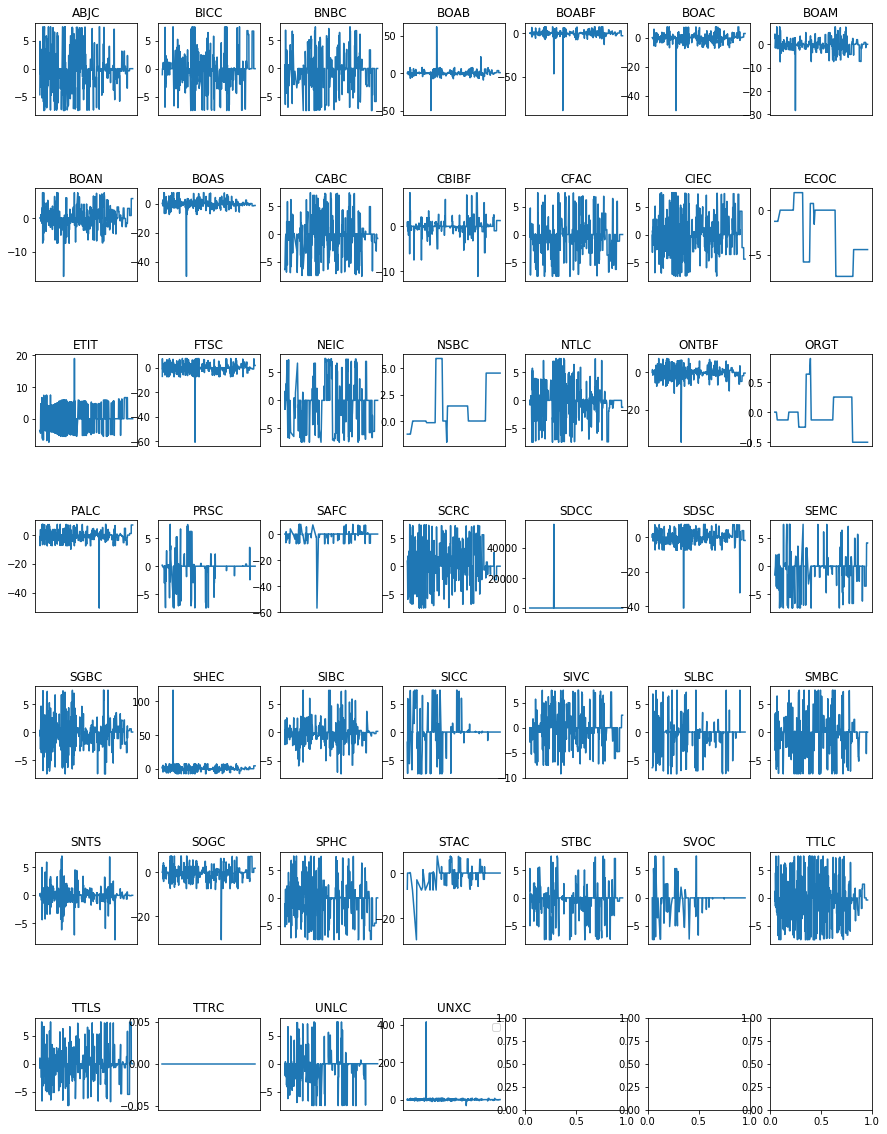

In [25]:
grouped = df_variation.groupby("Symbole")
rowlength = grouped.ngroups/7
fig, axs = plt.subplots(figsize=(15,20), nrows=7, ncols = int(np.ceil(rowlength)),gridspec_kw=dict(hspace=0.8))
targets = zip(grouped.groups.keys(), axs.flatten())

for i, (key, ax) in enumerate(targets):
    df_grouped = grouped.get_group(key)
    ax.plot(df_grouped["Date"], df_grouped["Variation"])
    ax.set_title("%s"%key)
    ax.axes.xaxis.set_visible(False)
ax.legend()

## MODELISATION ##

Dans cette partie, il faut:

- Prediction univariée
- Prendre en compte les produits financiers appartenant à un même secteur

**METHODES TRADITIONNELLES**

In [27]:
## Tester sur une action
data_ttlc = df_variation[df_variation["Symbole"]=="TTLC"][["Date","Variation"]]
data_ttlc.shape

(719, 2)

In [33]:
data_ttlc_v1 = data_ttlc.sort_values(by='Date').set_index("Date") 

In [28]:
data_ttlc.head(2)

,Date,Variation
36,2016-08-09,-0.59
75,2016-08-10,0.59


- VISUALIZATION

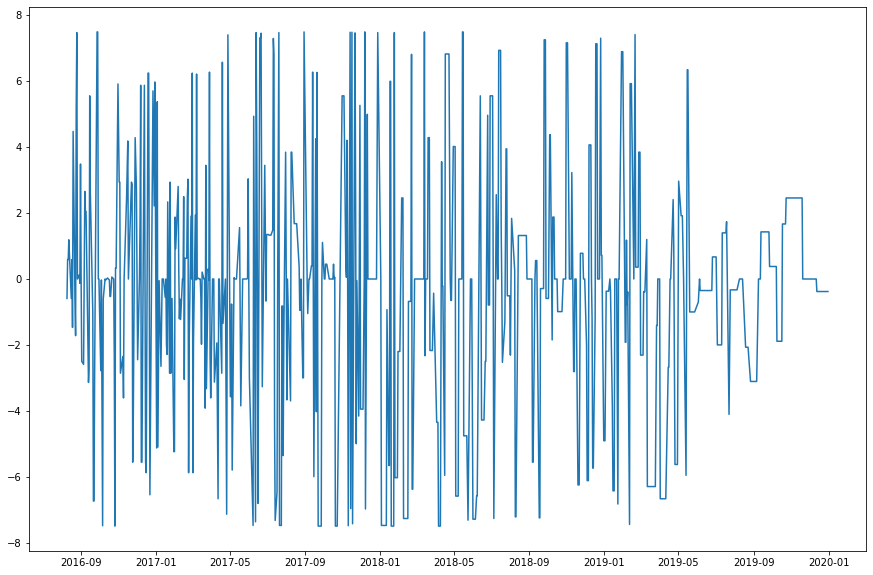

In [29]:
plt.figure(figsize=(15,10))
plt.plot(data_ttlc["Date"],data_ttlc["Variation"])

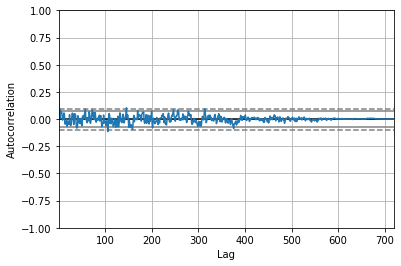

In [52]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data_ttlc_v1)

D'après ce graphique, il n'y a pas de correlation entre la valeur présente et les valeurs antérieures

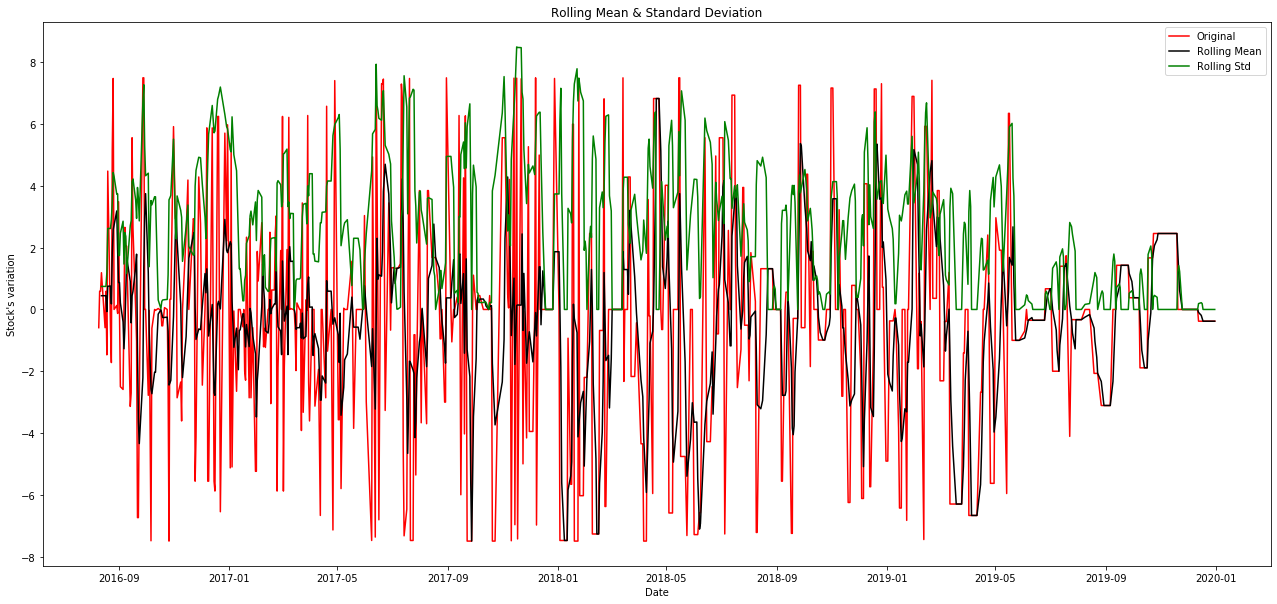

Test statistic:  -11.1904820179846
p-value:  2.3757616837033473e-20
Critical Values: {'1%': -3.4395289262948894, '5%': -2.8655907692307694, '10%': -2.5689271030368235}


In [34]:
## Stationarity of time series
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    #rolmean = pd.rolling_mean(ts, window=6)
    rolmean = ts.rolling(4).mean()
    #rolstd = pd.rolling_std(ts, window=6)
    rolstd = ts.rolling(4).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Stock's variation")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
check_mean_std(data_ttlc_v1)
check_adfuller(data_ttlc_v1.Variation)

La série est stationnaire. Selon le test de Duckey-Fuller la p-value est inférieur à 1%. Donc avec une certitude de 99%, la série est stationnaire.

Puisque la série est stationnaire, nous pouvons passer à la modélisation.

MODELISATION

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


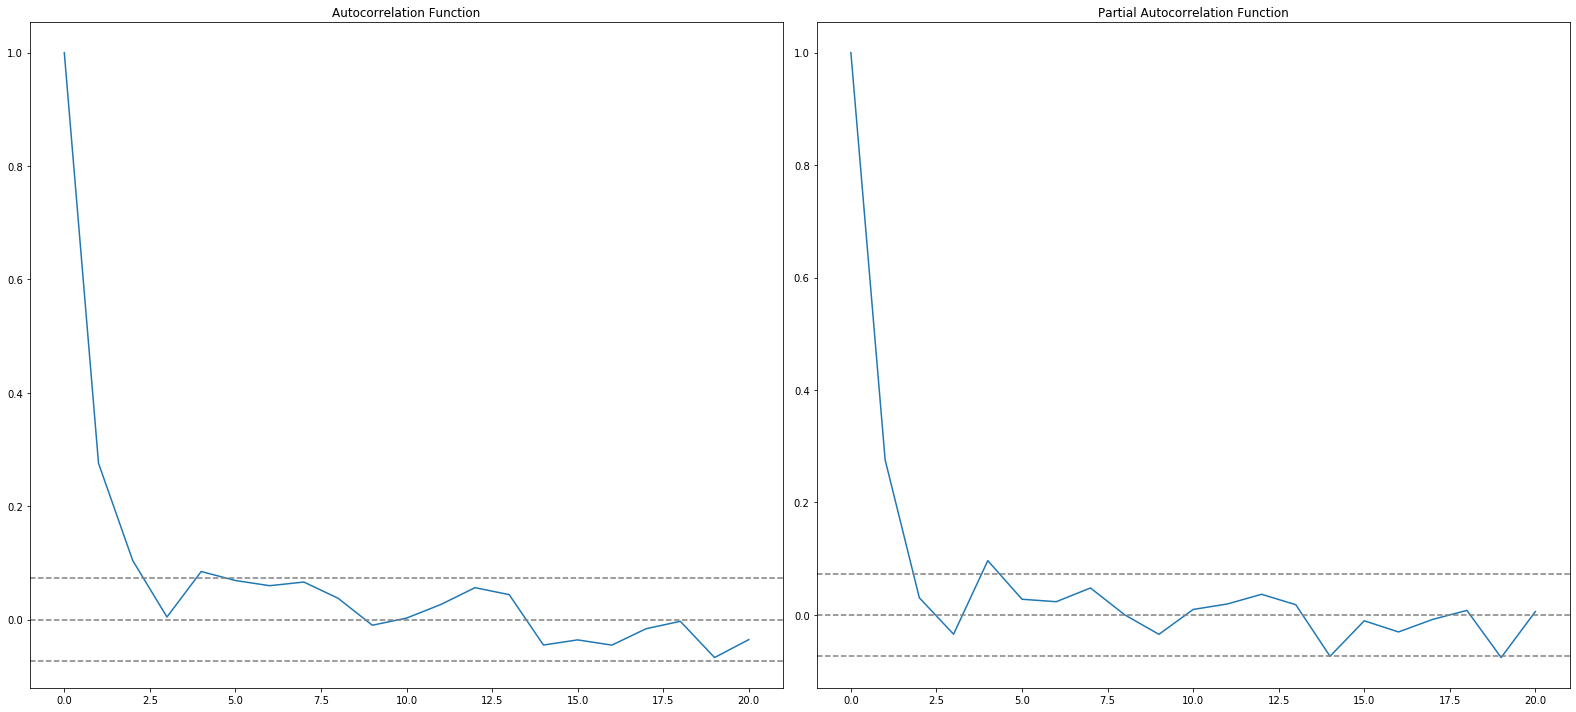

In [35]:
## ARIMA(p,d,q)
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(data_ttlc_v1, nlags=20)
lag_pacf = pacf(data_ttlc_v1, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_ttlc_v1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_ttlc_v1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_ttlc_v1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_ttlc_v1)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Ces 2 graphes permettent d'identifier la valeur de p et q du modele ARIMA(p,d,q). Le PACF sert à déterminer p et ACF celui de q. Le paramètre d signifie le nombre de différenciation pour absorber la non-saisonnalité de la série.

Dans notre cas, p=q=1

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


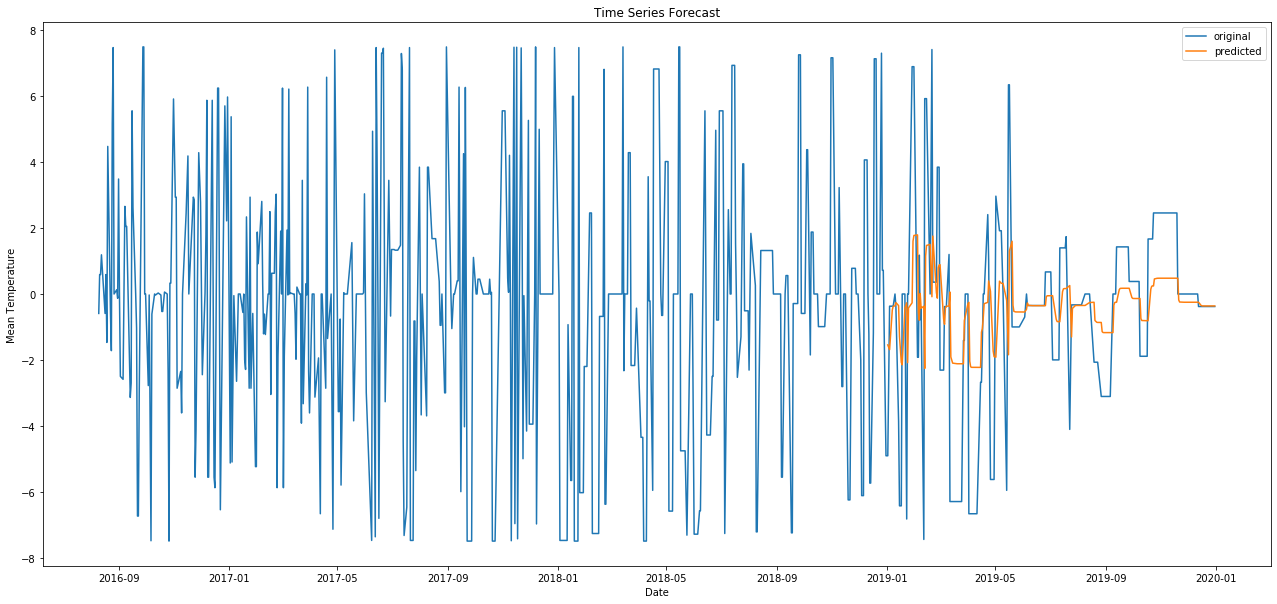

In [51]:
# ARIMA LİBRARY
from statsmodels.tsa.arima_model import ARIMA
import datetime

# fit model
model = ARIMA(data_ttlc_v1, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit(disp=0)

# predict
start_index = datetime.datetime.strptime("2019-01-02", "%Y-%m-%d").strftime("%Y-%m-%d")
end_index = datetime.datetime.strptime("2019-12-31", "%Y-%m-%d").strftime("%Y-%m-%d")

forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.plot(data_ttlc.Date,data_ttlc.Variation,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error

predictions = model_fit.predict()
rmse = sqrt(mean_squared_error(data_ttlc.Variation, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.582


**METHODES RECURRENTS**